In [130]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import pandas as pd
import datetime
import os

In [131]:
def update_connections(n, T, A, opinions, confidence):
    new_A = np.zeros_like(A)
    for i in range(n):
        for j in range(i + 1, n):
            disagreements = np.abs(opinions[i] - opinions[j])
            similarities = (disagreements <= confidence).sum()
            S_ij = similarities / T
            P_ij = 1 / (1 + np.exp(-10 * (S_ij - 0.05)))  # sigmoid函数作为新的连接概率
            new_A[i, j] = new_A[j, i] = np.random.rand() < P_ij
    return new_A

In [132]:
def update_opinions(n, T, A, opinions, confidence):
    new_opinions = opinions.copy()
    for i in range(n):
        for j in range(n):
            if A[i, j] == 1:    
                disagreements = np.abs(opinions[i] - opinions[j])
                for k in range(T):
                    # 计算协商范围
                    similarities = (disagreements <= confidence[k]).sum()
                    differences = T - similarities
                    mu = float('inf') if differences == 0 \
                        else confidence[k] * similarities / differences
                    if disagreements[k] <= mu:
                        P_ij = 1 / (1 + np.exp(-10 * (disagreements[k] - 0.05)))
                        new_opinions[i, k] = (1 - P_ij) * opinions[i, k] + P_ij * opinions[j, k]
                        new_opinions[j, k] = (1 - P_ij) * opinions[j, k] + P_ij * opinions[i, k]
    return new_opinions


In [133]:
def create_ba_network(n, m):
    """
    生成一个BA无标度网络。
    :param n: 网络中的节点总数
    :param m: 每个新增节点连接的旧节点数
    :return: BA网络的邻接矩阵
    """
    ba = nx.barabasi_albert_graph(n, m)
    return nx.to_numpy_array(ba)

In [134]:
def create_ws_network(n, k, p):
    """
    生成一个WS小世界网络。
    :param n: 网络中的节点数量
    :param k: 每个节点的邻居数（最近的k/2个节点）
    :param p: 重连边的概率
    :return: WS小世界网络的邻接矩阵
    """
    ws = nx.watts_strogatz_graph(n, k, p)
    return nx.to_numpy_array(ws)

In [135]:
def create_community_network(n, block_sizes, p_intra, p_inter):
    """
    生成一个社团结构网络。
    :param n: 网络中的节点数量
    :param block_sizes: 各社团内的节点数列表
    :param p_intra: 社团内节点之间连接的概率
    :param p_inter: 社团间节点之间连接的概率
    :return: 社团结构网络的邻接矩阵
    """
    sizes = [int(n * size) for size in block_sizes]
    probs = [[p_intra if i == j else p_inter for j in range(len(sizes))] for i in range(len(sizes))]
    community = nx.stochastic_block_model(sizes, probs)
    return nx.to_numpy_array(community)


In [136]:
def run(n, T, A, label, max_steps=30):
    """
    :param n: 网络中的节点（个体）数量
    :param T: 话题数量
    :param A: 初始邻接矩阵
    :param label: 具体使用的网络类型
    :max_steps: 最大迭代次数
    """
    # 初始化观点向量，每个话题的观点值为标准正态分布随机样本
    #opinions = np.random.randn(n, T)
     # 定义截断正态分布的参数
    a, b = -1, 1  # 截断范围
    loc, scale = 0, 1  # 均值和标准差

    # 创建一个 n x T 的矩阵，每列满足截断正态分布
    opinions = np.zeros((n, T))
    for i in range(T):
        opinions[:, i] = truncnorm(a=(a - loc) / scale, b=(b - loc) / scale, loc=loc, scale=scale).rvs(size=n)

    # 为每个话题生成置信度ε_k，并确保值在0到1之间
    confidence = truncnorm(a=0, b=2, loc=0, scale=1).rvs(size=T)

    # 随机选择1个话题作为错误信息
    topic_to_track = np.random.choice(range(T), 1, replace=False)[0]
    
    time_stamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    file_name = f'{label}-{time_stamp}'
    folder_name = f'logs/{file_name}'
    if not os.path.exists('logs'):
        os.makedirs('logs')
    os.makedirs(folder_name)

    # 将初始观点保存
    pd.DataFrame(opinions).to_csv(f'{folder_name}/{file_name}-ini_opn.csv', index=False)
    
    # 将初始邻接矩阵保存
    pd.DataFrame(A).to_csv(f'{folder_name}/{file_name}-ini_adj.csv', index=False)

    # 保存初始网络结构图
    G = nx.from_numpy_array(A)
    plt.figure(figsize=(8, 8))  # 设置图形大小
    nx.draw(G, with_labels=False, node_color='lightgreen', node_size=1000, edge_color='gray', font_size=15, font_color='black', width=2)
    plt.title(f'Graph Visualization ({label})')
    plt.subplots_adjust(top=0.85)
    plt.savefig(f'{folder_name}/{file_name}-ini_net.png', bbox_inches='tight')

    # 针对选出来的那个带标记的话题：初始观点最大最小值，均值，中位数，标准差
    # 保留两位小数
    selected = opinions[:, topic_to_track]
    stats_data = {
        'Max': [np.round(np.max(selected), 2)],
        'Min': [np.round(np.min(selected), 2)],
        'Mean': [np.round(np.mean(selected), 2)],
        'Median': [np.round(np.median(selected), 2)],
        'Std': [np.round(np.std(selected), 2)]
    }
    pd.DataFrame(stats_data).to_csv(f'{folder_name}/{file_name}-ini_stats.csv', index=False)

    # 话题的置信阈值
    pd.DataFrame(confidence.reshape(1, -1)).to_csv(f'{folder_name}/{file_name}-conf.csv', index=False)
    
    # 存储每个个体的观点历史
    opinions_history = np.zeros((n, max_steps))  
    
    for step in range(max_steps):
        new_A = update_connections(n, T, A, opinions, confidence)
        new_opinions = update_opinions(n, T, new_A, opinions, confidence)
        
        # 存储当前所有个体的选定话题的观点
        opinions_history[:, step] = new_opinions[:, topic_to_track]
        
        # 检查是否达到稳态
        if np.allclose(new_A, A) and np.allclose(new_opinions, opinions):
            break
        
        A, opinions = new_A, new_opinions

    # 将数据保存到CSV文件
    pd.DataFrame(opinions_history).to_csv(f'{folder_name}/{file_name}.csv', index=False)

    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.plot(opinions_history[i])

    plt.xlabel(f'Time Steps ({label})')
    plt.ylabel('Individual Opinions')
    plt.title(f'Number of individuals={n}')
    plt.savefig(f'{folder_name}/{file_name}.png')
    plt.show()

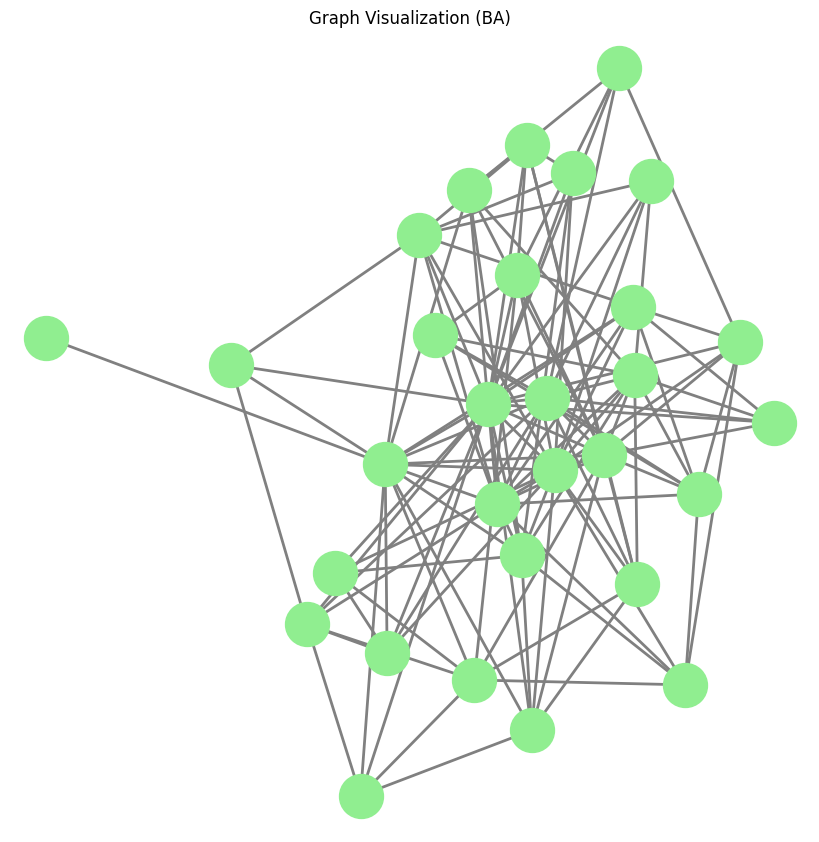

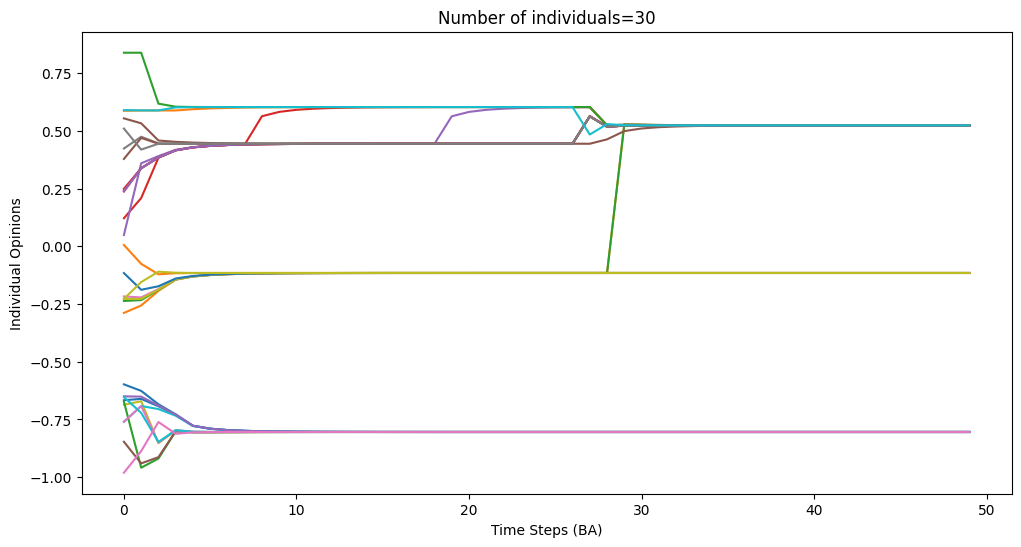

In [137]:
n = 30
T = 20
run(n=n, T=T, label='BA', A=create_ba_network(n, 5), max_steps=50)

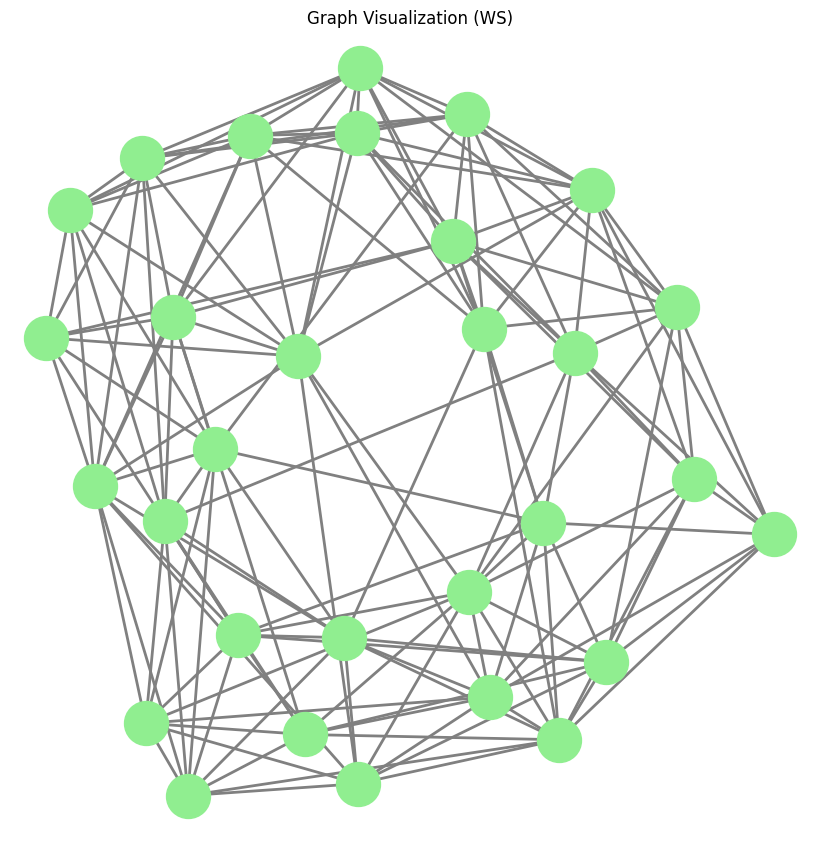

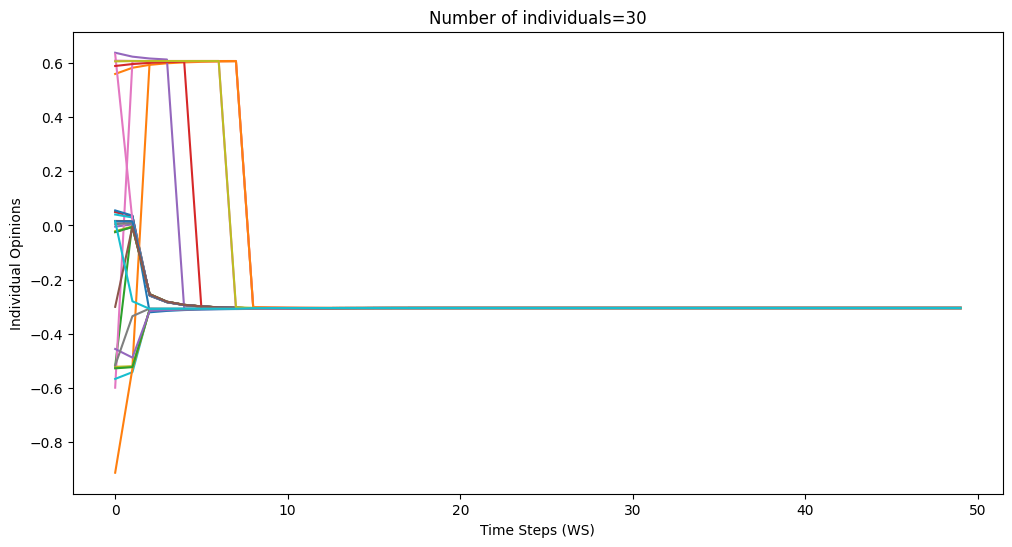

In [138]:
run(n=n, T=T, label='WS', A=create_ws_network(n=n, k=10, p=0.1), max_steps=50)

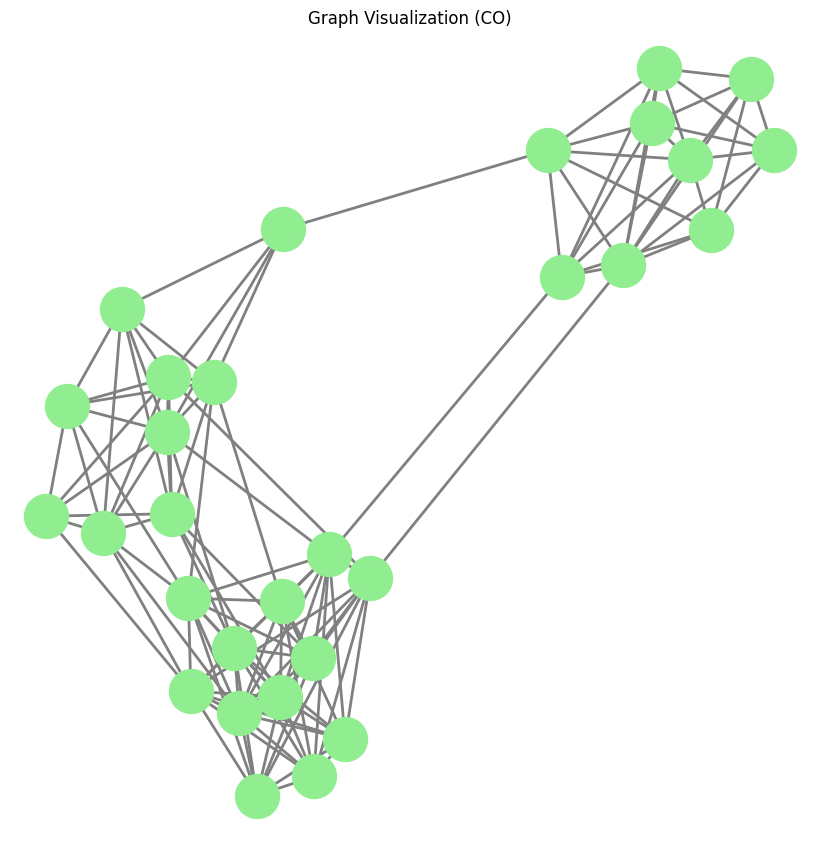

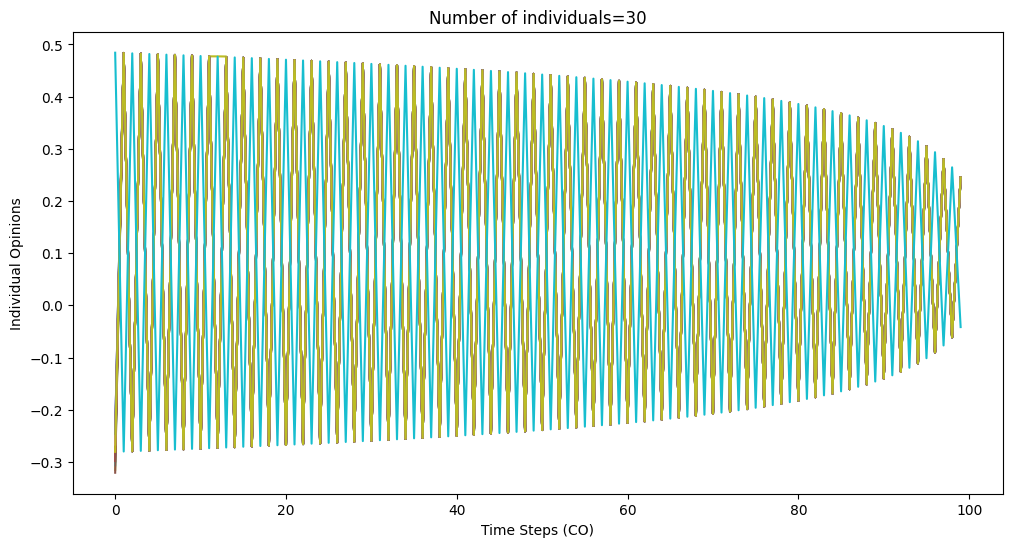

In [139]:
run(n=n, 
    T=T, 
    label='CO',
    A=create_community_network(
        n=n, 
        block_sizes=[0.4, 0.3, 0.3], 
        p_intra=0.8,
        p_inter=0.05), 
    max_steps=100)

In [128]:
def plot_from_csv(csv_file: str):
    """
    从CSV文件读取数据并绘制图表。
    :param csv_file: 存储观点历史的CSV文件路径。        
    """
    # 读取CSV文件
    df = pd.read_csv(csv_file)

    # 读取标签
    # BA：无标度网络
    # WS：小世界网络
    # CO：社团结构网络
    label = csv_file.split('/')[-1].split('-')[0]
    
    # 转换为 numpy 数组以便绘图
    data = df.values
    
    # 绘图
    plt.figure(figsize=(12, 6))
    for i in range(data.shape[0]):
        plt.plot(data[i])
    
    plt.xlabel(f'Time Steps ({label})')
    plt.ylabel('Individual Opinions')
    plt.title(f'Number of individuals={n}')
    plt.show()

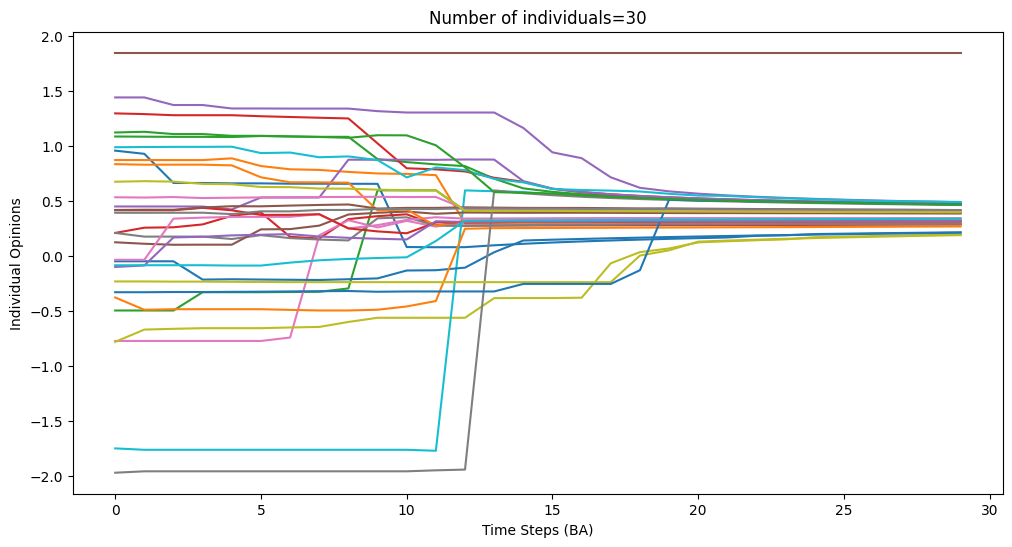

In [129]:
plot_from_csv('logs/BA-20240625_191728/BA-20240625_191728.csv')

以下是用于调试局部效果的部分，与正文代码无关

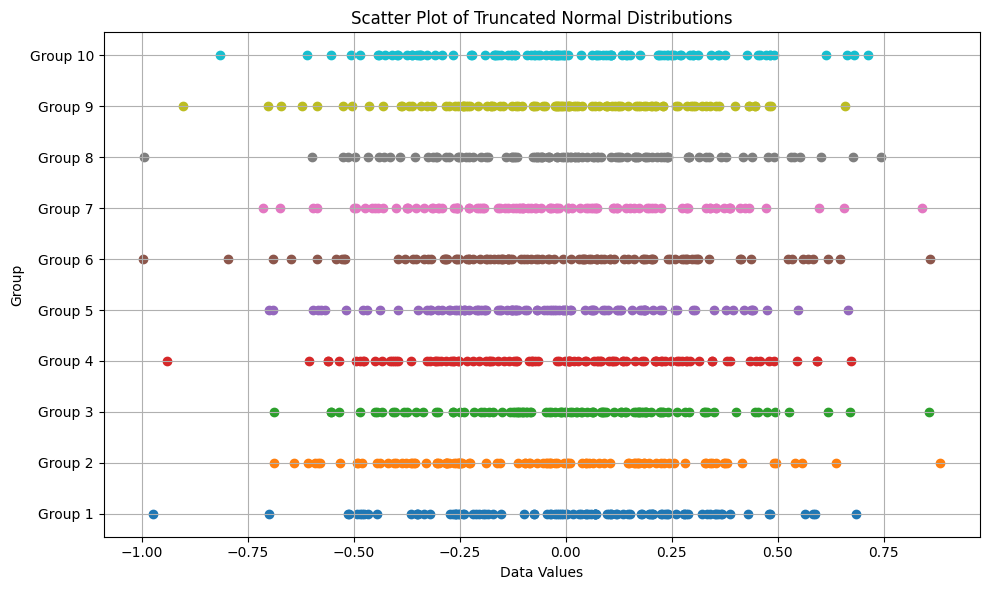

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

def generate_truncated_normal(a, b, loc, scale, size):
    # Generate truncated normal distribution within [a, b]
    return truncnorm(a=(a - loc) / scale, b=(b - loc) / scale, loc=loc, scale=scale).rvs(size=1000)

def plot_scatter(data):
    # Create scatter plot
    plt.figure(figsize=(10, 6))

    # Plot each group's scatter
    for i, group_data in enumerate(data):
        y_coords = np.ones_like(group_data) * (i + 1)  # Generate y coordinates for the group
        plt.scatter(group_data, y_coords, marker='o')

    # Set plot attributes
    plt.title('Scatter Plot of Truncated Normal Distributions')
    plt.xlabel('Data Values')
    plt.ylabel('Group')
    plt.yticks(np.arange(1, len(data) + 1), ['Group {}'.format(i + 1) for i in range(len(data))])
    plt.grid(True)

    # Show plot
    plt.tight_layout()
    plt.show()

# Example usage to generate T samples within [-1, 1] from truncated normal distribution
T = 10  # Number of samples
loc = 0  # Mean of the truncated normal distribution
scale = 0.3  # Standard deviation of the truncated normal distribution

# Generate T samples within [-1, 1]
samples = generate_truncated_normal(a=-1, b=1, loc=loc, scale=scale, size=T)

# Reshape samples for plotting (each row represents one group)
samples = np.reshape(samples, (T, -1))

# Plot the generated samples
plot_scatter(samples)


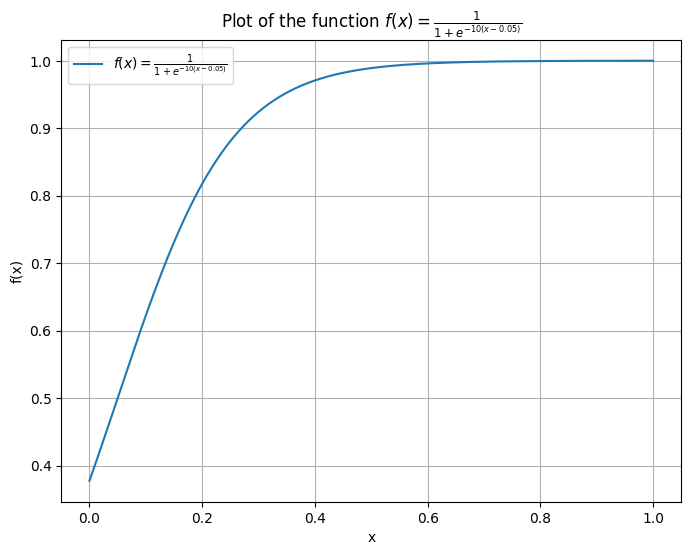

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# 定义函数 f(x)
def f(x):
    return 1 / (1 + np.exp(-10 * (x - 0.05)))

# 生成 x 值
x = np.linspace(0, 1, 400)
y = f(x)

# 绘制函数图像
plt.figure(figsize=(8, 6))
plt.plot(x, y, label=r'$f(x) = \frac{1}{1 + e^{-10(x - 0.05)}}$')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Plot of the function $f(x) = \\frac{1}{1 + e^{-10(x - 0.05)}}$')
plt.legend()
plt.grid(True)
plt.show()


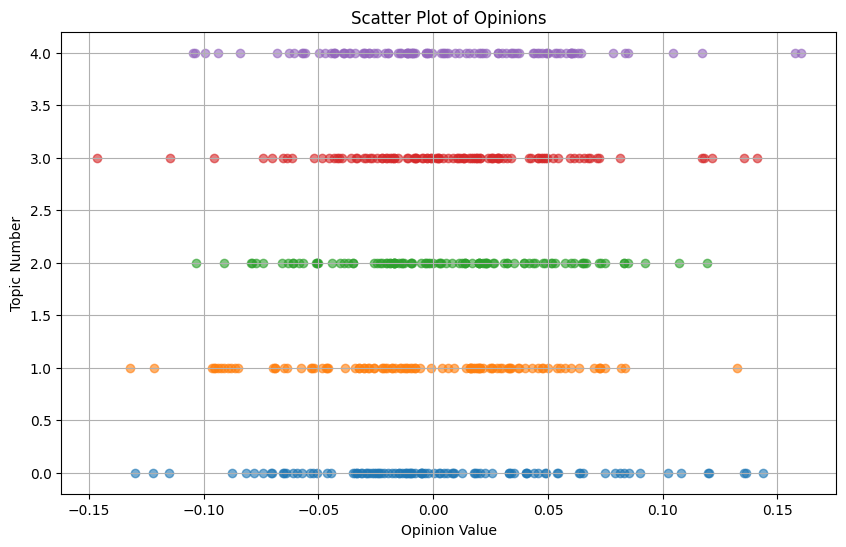

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

def generate_opinions(n, T):
    # 定义截断正态分布的参数
    a, b = -1, 1  # 截断范围
    loc, scale = 0, 0.05  # 均值和标准差

    # 创建一个 n x T 的矩阵，每列满足截断正态分布
    Opinions = np.zeros((n, T))
    for t in range(T):
        Opinions[:, t] = truncnorm(a=(a - loc) / scale, b=(b - loc) / scale, loc=loc, scale=scale).rvs(size=n)
    
    return Opinions

def plot_opinions(opinions):
    n, T = opinions.shape
    plt.figure(figsize=(10, 6))
    
    for t in range(T):
        plt.scatter(opinions[:, t], [t] * n, label=f'Topic {t+1}', alpha=0.6)

    plt.xlabel('Opinion Value')
    plt.ylabel('Topic Number')
    plt.title('Scatter Plot of Opinions')
    #plt.legend()
    plt.grid(True)
    plt.show()

# 示例用法
n = 100  # 行数
T = 5  # 列数
Opinions = generate_opinions(n, T)
#print("Generated Opinions matrix:")
#print(Opinions)

# 绘制 Opinions 矩阵
plot_opinions(Opinions)
